# Lab 3 (Part 1): Convolutional NNs for CIFAR 10


------------------------------------------------------
*Neural Networks. Bachelor in Data Science and Engineering*

*Pablo M. Olmos pamartin@ing.uc3m.es*

*Aurora Cobo Aguilera acobo@tsc.uc3m.es*

------------------------------------------------------


In this third part of the lab, we will use a data set of (small) natural images known as  [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Our goal is to present i) how CNN layers are used in Pytorch, and ii) evaluate the performance of a simple CNN over this dataset.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

**IMPORTANT NOTE:** In this notebook I show you how to speed up NN training using Graphical Processing Units (GPUs). To make sure you use a Google Colaboratory server equipped with a GPU, go to `Edit` --> `Notebook Settings` --> Select GPU in `Hardware Accelerator`

In [107]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://pytorch.org/tutorials/_images/cifar10.png", width=400, height=300)

In [108]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

## Part I. Download CIFAR10 with `torchvision`

The code below will download the CIFAR10 dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [109]:
import torch
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [110]:
traindata = iter(trainloader)

images, labels = next(traindata)

print(images[1].shape)

torch.Size([3, 32, 32])


In [111]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

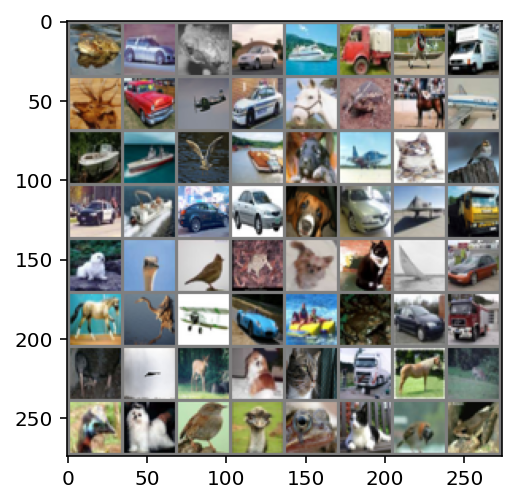

In [112]:
imshow(utils.make_grid(images))

> **Exercise:** Create a validation set using the 20% of train images

In [113]:
import copy

print(trainloader.dataset.data.shape)
def create_validation_set(trainloader, size=0.8):
    validloader = copy.deepcopy(trainloader)
    pctg = int(len(trainloader.dataset.data) * size)

    trainloader.dataset.data = trainloader.dataset.data[:pctg,:,:]
    trainloader.dataset.targets = trainloader.dataset.targets[:pctg]
    #And the rest for validation
    validloader.dataset.data = validloader.dataset.data[pctg:,:,:]
    validloader.dataset.targets = validloader.dataset.targets[pctg:]

    return trainloader, validloader

trainloader, validloader = create_validation_set(trainloader)
print(trainloader.dataset.data.shape, validloader.dataset.data.shape)

(50000, 32, 32, 3)
(40000, 32, 32, 3) (10000, 32, 32, 3)


## Part II. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. See the original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [114]:
Image(url= "https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that CIFAR-10 images are composed by **3 input color maps**, each of dimension $32\times32$.

> **Exercise:** Complete the following code that defines the above CNN. But first read the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html) documentation.

In [115]:
class Lenet5(nn.Module):

    def __init__(self, dimx, nlabels): #Nlabels will be 10 in our case
        super().__init__()
        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)
        # Linear layers
        self.linear1 = nn.Linear(16*5*5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, nlabels)

        # Relu activation function
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1, 16 * self.final_dim**2) 
        # Pass the tensor through the Dense Layers
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.logsoftmax(self.linear3(x))
        return x


Now the network is defined, by now you should know how to move forward by your own!!

> **Exercise:** Extend the class to incorporate a training method, to evaluate the both the validation and train losses and to evaluate the classification performance in a set.

In [116]:
class Lenet5_extended(Lenet5):

    def __init__(self, epochs=100, lr=0.001, *args, **kwargs):  # Nlabels will be 10 in our case
        super().__init__(*args, **kwargs)

        self.lr = lr
        self.epochs = epochs

        self.optim = optim.Adam(self.parameters(), self.lr)
        self.criterion = nn.NLLLoss()
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        self.valid_loss_during_training = []

    def trainloop(self, trainloader, validloader, print_every = 5):
        # Optimization Loop
        for e in range(int(self.epochs)):
            start_time = time.time()
            # Random data permutation at each epoch
            running_loss = 0.
            val_running_loss = 0.
            self.train()
            for images, labels in trainloader:
                self.optim.zero_grad()  # TO RESET GRADIENTS!
                out = self.forward(images)
                loss = self.criterion(out, labels)
                
                running_loss += loss.item()
                loss.backward()
                self.optim.step()  

            with torch.no_grad():
                for images, labels in validloader:
                    val_out = self.forward(images)
                    val_loss = self.criterion(val_out,labels)
                    val_running_loss += val_loss.item()

            self.loss_during_training.append(running_loss/len(trainloader))    
            self.valid_loss_during_training.append(val_running_loss/len(validloader))

            if print_every == -1:
                pass
            elif (e % print_every == 0):
                print(f"Epoch {e+1}. Training loss: {self.loss_during_training[-1]},\n \
                        Validation loss: {self.valid_loss_during_training[-1]},\n \
                        Time per epoch: {time.time() - start_time} seconds\n")
    
    def evaluate(self, dataloader):
        # Turn off gradients for validation, saves memory and computations
        self.eval()
        with torch.no_grad():
            loss, accuracy = 0, 0
            for images, labels in dataloader:
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
        self.train()
        return accuracy/len(dataloader)


> **Exercise:** Train the model for 5 epochs, plot the train/validation loss during training, and compute the train and validation performance. It will take some time!!

In [117]:
epochs = 5
my_CNN = Lenet5_extended(
    dimx=32,
    nlabels=10,
    epochs=epochs,
    lr=0.001
)
my_CNN.trainloop(trainloader, validloader, print_every = 1)

Epoch 1. Training loss: 1.7072400285720826,
                         Validation loss: 1.5144711322845168,
                         Time per epoch: 19.44717502593994 seconds

Epoch 2. Training loss: 1.3967883261680603,
                         Validation loss: 1.356525806105061,
                         Time per epoch: 19.409836530685425 seconds

Epoch 3. Training loss: 1.2805638856887818,
                         Validation loss: 1.2534620883358512,
                         Time per epoch: 19.561233282089233 seconds

Epoch 4. Training loss: 1.1977675317764283,
                         Validation loss: 1.2156933929510176,
                         Time per epoch: 19.371020793914795 seconds

Epoch 5. Training loss: 1.126668417930603,
                         Validation loss: 1.1805327117063438,
                         Time per epoch: 19.349578619003296 seconds



In [118]:
print(f"Training accuracy: {my_CNN.evaluate(trainloader)}")
print(f"Training accuracy: {my_CNN.evaluate(validloader)}")

Training accuracy: 0.6113499999046326
Training accuracy: 0.5740445852279663


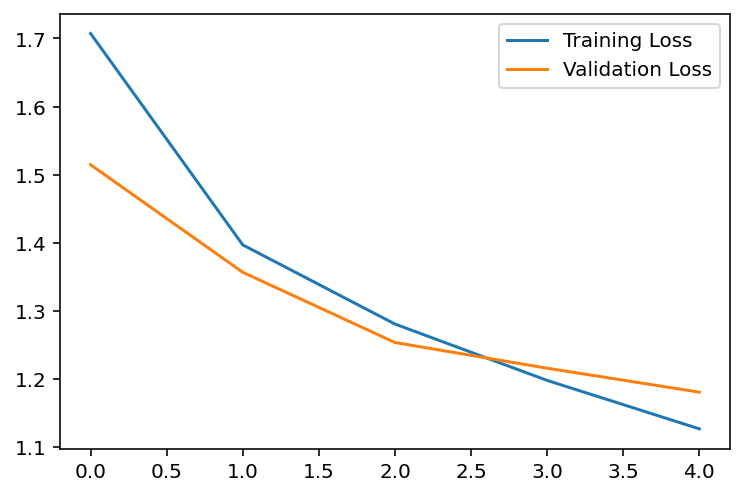

In [119]:
plt.plot(range(epochs),
         my_CNN.loss_during_training,
         label='Training Loss')

plt.plot(range(epochs),
         my_CNN.valid_loss_during_training,
         label='Validation Loss')

plt.legend()
plt.show()

## Part III. GPU-based training

As you noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

> **Exercise:** Complete the following class, which implements the CNN training and validation using a GPU (if possible). 

**Note: Google Colab Recommended**. When running the notebook in Google Colab, make sure you first to `Edit -- Notebook settings` and **select a GPU as Hardware accelerator.**



In [120]:
class Lenet5_extended_GPU(Lenet5_extended):
    
    #Your code here
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def trainloop(self, trainloader, validloader):
        # Optimization Loop
        for e in range(int(self.epochs)):
            start_time = time.time()
            # Random data permutation at each epoch
            running_loss, val_running_loss = 0.0, 0.0
            for images, labels in trainloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                # images, labels = images.cuda(), labels.cuda()
        
                self.optim.zero_grad()  # Reset Gradients!
                out = self.forward(images)
                loss = self.criterion(out, labels)

                running_loss += loss.item()
                loss.backward()  # Compute gradients
                self.optim.step()  # SGD stem
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                for images, labels in validloader:  
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)
                    # images, labels = images.cuda(), labels.cuda()
                    # Compute output for input minibatch
                    out = self.forward(images)
                    loss = self.criterion(out, labels)
                    val_running_loss += loss.item()

            # Validation Loss
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(val_running_loss/len(validloader))

            if(e % 1 == 0): # Every epoch
                print(f"Epoch {e+1}. Training loss: {self.loss_during_training[-1]},\n \
                        Validation loss: {self.valid_loss_during_training[-1]},\n \
                        Time per epoch: {time.time() - start_time} seconds\n")
                
    def evaluate(self, dataloader):
        # Turn off gradients for validation, saves memory and computations
        self.eval()
        with torch.no_grad():
            loss, accuracy = 0, 0
            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                # images, labels = images.cuda(), labels.cuda()

                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
        self.train()
        return accuracy/len(dataloader)


In [121]:
epochs = 5
my_CNN_GPU = Lenet5_extended_GPU(
    dimx=32,
    nlabels=10,
    epochs=epochs,
    lr=0.001
)
my_CNN_GPU.trainloop(trainloader, validloader)

Epoch 1. Training loss: 1.6901058782577514,
                         Validation loss: 1.4934545725014559,
                         Time per epoch: 19.12164545059204 seconds

Epoch 2. Training loss: 1.3789308973312377,
                         Validation loss: 1.317543841471338,
                         Time per epoch: 19.353301525115967 seconds

Epoch 3. Training loss: 1.2618580451011658,
                         Validation loss: 1.2512829611255865,
                         Time per epoch: 19.44520926475525 seconds

Epoch 4. Training loss: 1.1851298064231872,
                         Validation loss: 1.1954180043973741,
                         Time per epoch: 19.32022738456726 seconds

Epoch 5. Training loss: 1.1248171610832214,
                         Validation loss: 1.1652585689429265,
                         Time per epoch: 19.381654024124146 seconds



In [122]:
print(f"Training accuracy: {my_CNN_GPU.evaluate(trainloader)}")
print(f"Validation accuracy: {my_CNN_GPU.evaluate(validloader)}")

Training accuracy: 0.6236749887466431
Validation accuracy: 0.5849920511245728


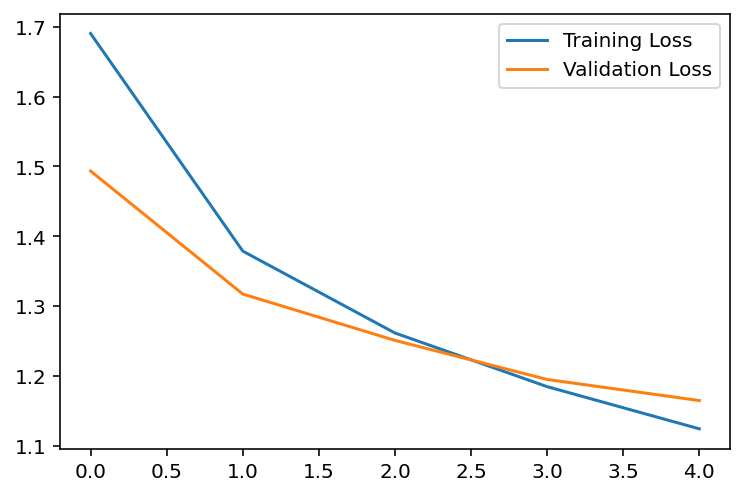

In [123]:
plt.plot(range(epochs),
         my_CNN_GPU.loss_during_training,
         label='Training Loss')

plt.plot(range(epochs),
         my_CNN_GPU.valid_loss_during_training,
         label='Validation Loss')

plt.legend()
plt.show()

With a GPU, you will see that the time per epoch roughly decreases significantly. As we train deeper and much more complex networks, **this difference grows exponentially fast**. Using GPUs is a must for lage-scale deployment.

## Part IV. Regularize the network and compare with a MLP

> **Exercise**: Now that you know how to train the CNN network, your goals are:
> - Check that the CNN is able to overfit
> - Regularize the network with both early stopping and dropout. In my experience, it is more efficient to include the dropout layers in between the final MLP layers, rather than in between convolutional layers. Note that once you include dropout, it wil take more epochs to converge. The more dropout layers, the more epochs typically you have to run. For this exercise, run at least 50 epochs.
> - Check the train/validation/test performance, plot the train and validation losses

In [124]:
class Lenet5_extended_GPU_with_dropout(Lenet5_extended_GPU):
    
    def __init__(self, p_drop, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1, 16 * self.final_dim**2) 
        # Pass the tensor through the Dense Layers
        x = self.relu(self.linear1(x))
        x = self.dropout(x)  # DROPOUT
        x = self.relu(self.linear2(x))
        x = self.dropout(x)  # DROPOUT
        x = self.logsoftmax(self.linear3(x))
        return x

In [125]:
epochs = 50
my_extended_CNN_GPU = Lenet5_extended_GPU_with_dropout(
    dimx=32,
    nlabels=10,
    epochs=epochs,
    lr=0.001,
    p_drop=0.25
)
my_extended_CNN_GPU.trainloop(trainloader, validloader)

Epoch 1. Training loss: 1.7573173612594604,
                         Validation loss: 1.562411857258742,
                         Time per epoch: 19.37040877342224 seconds

Epoch 2. Training loss: 1.479024290084839,
                         Validation loss: 1.4491405760406688,
                         Time per epoch: 19.47519326210022 seconds

Epoch 3. Training loss: 1.3560646928787232,
                         Validation loss: 1.3405872769416518,
                         Time per epoch: 19.45582342147827 seconds

Epoch 4. Training loss: 1.2770162017822266,
                         Validation loss: 1.2751184447555786,
                         Time per epoch: 19.474437713623047 seconds

Epoch 5. Training loss: 1.213334580230713,
                         Validation loss: 1.2386016746994797,
                         Time per epoch: 19.651208877563477 seconds

Epoch 6. Training loss: 1.1629959197044373,
                         Validation loss: 1.2169532411417383,
                         

In [126]:
print(f"Training accuracy: {my_extended_CNN_GPU.evaluate(trainloader)}")
print(f"Validation accuracy: {my_extended_CNN_GPU.evaluate(validloader)}")
print(f"Test accuracy: {my_extended_CNN_GPU.evaluate(testloader)}")

Training accuracy: 0.8289250135421753
Validation accuracy: 0.6445063948631287
Test accuracy: 0.6393312215805054


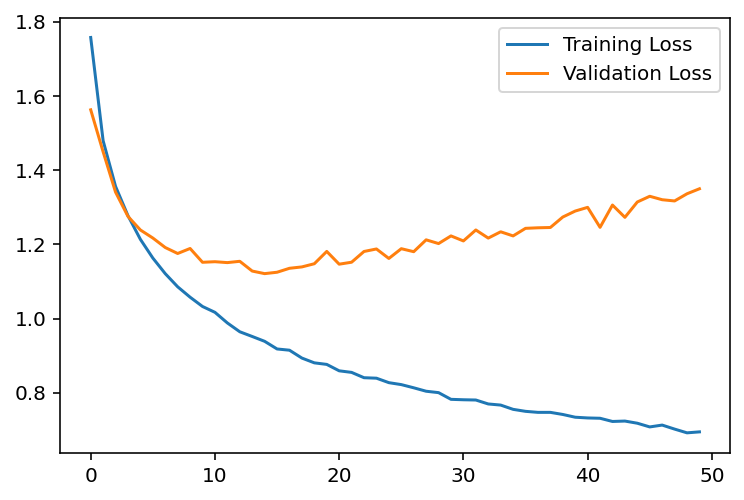

In [127]:
plt.plot(range(epochs),
         my_extended_CNN_GPU.loss_during_training,
         label='Training Loss')

plt.plot(range(epochs),
         my_extended_CNN_GPU.valid_loss_during_training,
         label='Validation Loss')

plt.legend()
plt.show()

### Train an MLP to compare the performance (Optional)

Train an MLP with 3-4 layers to compare the performance. Take into account that the input image has three color maps. If you stuck it into a vector, then the input dimension is 3x32x32 = 3072. An alternative is to compute the average between the three. Alternatively, you could use only one color map, or the average between three of them ...

In [128]:
#YOUR CODE HERE